# Baseline Evaluation

This notebook evaluates baseline retrieval methods (BM25 and TF-IDF) on TREC-COVID and Climate-Fever datasets.

## How to Run

1. Press "Run All" to execute all cells
2. All required files will be created automatically if missing
3. Metrics and plots will be saved to `data/eval/baseline/`


In [12]:
# Setup: imports and path configuration
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Notebook is located at notebook/eval/baseline.ipynb
project_root = Path.cwd().parents[1]

# Define core configuration
datasets = ["trec_covid", "climate_fever"]
retrieval_methods = ["bm25", "tfidf"]  # baseline retrieval methods we actually support
data_base = project_root / "data"

sys.path.insert(0, str(project_root / 'src'))

from eval import (
    compute_metrics_from_files,
    save_metrics_to_csv,
)
from eval.utils import (
    ensure_directory,
    create_summary_table,
)
from notebook.run_api import ensure_baseline_runs

print("Setup complete! Project root:", project_root)


Setup complete! Project root: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms


## Ensure ingest outputs and baseline runs

Use the programmatic ingest + retrieval API to materialize real artifacts under data/ingest/{dataset} and data/retrieval/baseline/ if they are missing.


In [13]:
# Ensure output directory exists
ensure_directory(data_base / "retrieval" / "baseline")
ensure_directory(data_base / "eval" / "baseline")

# Ensure baseline runs exist
runs = ensure_baseline_runs(datasets=datasets, retrieval_methods=retrieval_methods, top_k=100)
print("Baseline runs ensured:\n", json.dumps(runs, indent=2, default=str))

=== Dataset: trec_covid ===
[trec_covid] All requested baseline bm25 runs are valid; skipping all upstream work.
[trec_covid] All requested baseline tfidf runs are valid; skipping all upstream work.
=== Dataset: climate_fever ===
[climate_fever] All requested baseline bm25 runs are valid; skipping all upstream work.
[climate_fever] All requested baseline tfidf runs are valid; skipping all upstream work.
Baseline runs ensured:
 {
  "trec_covid": {
    "bm25": "C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\data\\retrieval\\baseline\\trec_covid_bm25.csv",
    "tfidf": "C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\data\\retrieval\\baseline\\trec_covid_tfidf.csv"
  },
  "climate_fever": {
    "bm25": "C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\data\\retrieval\\baseline\\climate_fever_bm25.csv",
    "tfidf": "C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-l

## Load and display dataset statistics

In [14]:
# Load and display dataset statistics from manifest.json
print("\n=== Dataset Statistics ===")
from ingest.core import get_ingested_dataset_paths

dataset_stats = {}
for dataset in datasets:
    paths = get_ingested_dataset_paths(dataset)
    if paths.manifest.exists():
        manifest_data = json.loads(paths.manifest.read_text(encoding="utf-8"))
        dataset_stats[dataset] = {
            "doc_count": manifest_data.get("doc_count", "N/A"),
            "query_count": manifest_data.get("query_count", "N/A"),
            "qrels_count": manifest_data.get("qrels_count", "N/A"),
            "vocab_size": manifest_data.get("vocab_size", "N/A"),
            "split": manifest_data.get("split", "N/A"),
        }
        print(f"{dataset}:")
        print(f"  Documents: {dataset_stats[dataset]['doc_count']}")
        print(f"  Queries: {dataset_stats[dataset]['query_count']}")
        print(f"  Qrels: {dataset_stats[dataset]['qrels_count']}")
        print(f"  Vocab size: {dataset_stats[dataset]['vocab_size']}")
        print(f"  Split: {dataset_stats[dataset]['split']}")

# Save dataset statistics to data/eval
if dataset_stats:
    stats_path = data_base / "eval" / "dataset_stats.json"
    ensure_directory(stats_path.parent)
    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(dataset_stats, f, indent=2)
    print(f"\nDataset statistics saved to: {stats_path}")


=== Dataset Statistics ===
trec_covid:
  Documents: 171332
  Queries: 50
  Qrels: 66336
  Vocab size: 50000
  Split: test
climate_fever:
  Documents: 5416593
  Queries: 1535
  Qrels: 4681
  Vocab size: 50000
  Split: test

Dataset statistics saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\dataset_stats.json


## Compute Metrics for All 4 Combos

Compute nDCG@10, MAP, Recall@100, MRR for:
- BM25 × TREC-COVID
- BM25 × Climate-Fever  
- TF-IDF × TREC-COVID
- TF-IDF × Climate-Fever


In [15]:
# Compute metrics for all combinations using real ingest outputs
all_metrics = {}

for dataset in datasets:
    qrels_path = data_base / "ingest" / dataset / "qrels.csv"

    for retrieval in retrieval_methods:
        run_path = data_base / "retrieval" / "baseline" / f"{dataset}_{retrieval}.csv"
        metric_path = data_base / "eval" / "baseline" / f"{dataset}_{retrieval}.csv"

        # Compute and save metrics
        metrics = compute_metrics_from_files(str(run_path), str(qrels_path), k=10)
        save_metrics_to_csv(
            metrics,
            str(metric_path),
            dataset=dataset,
            method="baseline",
            retrieval=retrieval,
        )

        all_metrics[(dataset, "baseline", retrieval)] = metrics

print("\nMetrics computation complete!")



Metrics computation complete!


## Summary Table


In [16]:
# Create and display summary table
summary_df = create_summary_table(all_metrics)
summary_path = data_base / "eval" / "baseline" / "summary.csv"
summary_df.to_csv(summary_path, index=False)

print("Summary Metrics Table:")
print(summary_df.to_string(index=False))
print(f"\nSaved to: {summary_path}")


Summary Metrics Table:
      dataset   method retrieval  ndcg@10      map  recall@100      mrr
   trec_covid baseline      bm25 0.364900 0.368874    0.055457 0.600733
   trec_covid baseline     tfidf 0.190612 0.259761    0.027966 0.396332
climate_fever baseline      bm25 0.088584 0.113680    0.277275 0.135199
climate_fever baseline     tfidf 0.025235 0.036801    0.183659 0.043266

Saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\baseline\summary.csv


## Plot nDCG@10 Comparison


Plot saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\baseline\ndcg.png


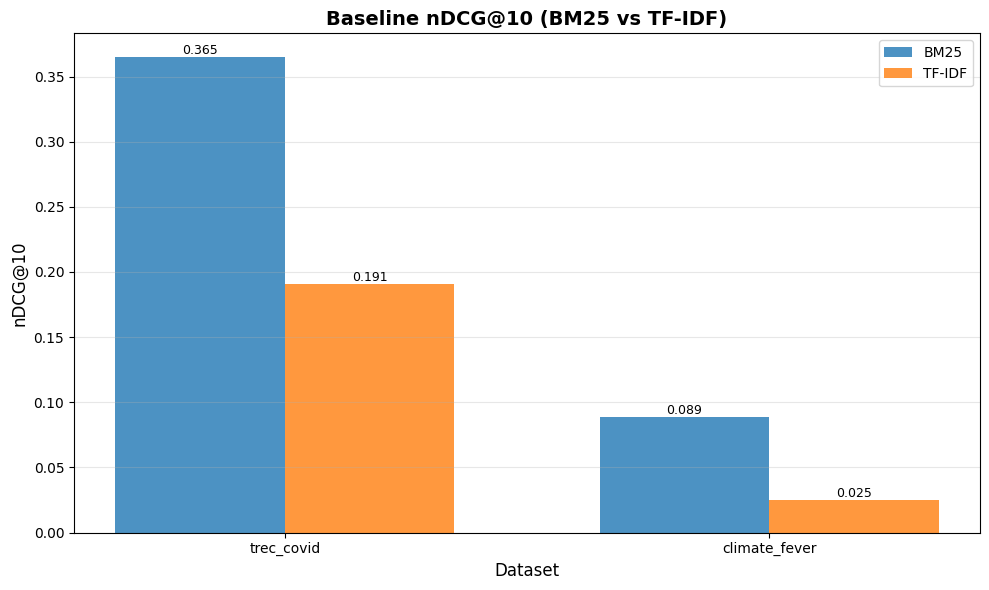

In [17]:
# Plot nDCG@10 comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(datasets))
width = 0.35

bm25_scores = [all_metrics[(d, "baseline", "bm25")]["ndcg@10"] for d in datasets]
tfidf_scores = [all_metrics[(d, "baseline", "tfidf")]["ndcg@10"] for d in datasets]

bars1 = ax.bar(x - width/2, bm25_scores, width, label="BM25", alpha=0.8)
bars2 = ax.bar(x + width/2, tfidf_scores, width, label="TF-IDF", alpha=0.8)

ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("nDCG@10", fontsize=12)
ax.set_title("Baseline nDCG@10 (BM25 vs TF-IDF)", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height,
                f"{height:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

# Save plot
plot_path = data_base / "eval" / "baseline" / "ndcg.png"
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Plot saved to: {plot_path}")
plt.show()


## Robustness Analysis: Compute Query Slices


In [18]:
# Compute query slices for each dataset using ingest outputs (queries + vocab)
from eval.robustness_slices import compute_query_slices, load_vocabulary

for dataset in datasets:
    vocab_path = data_base / "ingest" / dataset / "vocab_top50k.txt"
    queries_path = data_base / "ingest" / dataset / "queries.csv"
    slices_path = data_base / "eval" / f"{dataset}.csv"

    # Load vocabulary
    vocab = load_vocabulary(str(vocab_path), top_n=50000)

    # Load queries.csv (query_id,text,split)
    queries_df = pd.read_csv(queries_path)
    # Convert query_id to string to match run file format
    queries = {str(row["query_id"]): row["text"] for _, row in queries_df.iterrows()}

    for retrieval in retrieval_methods:
        run_path = data_base / "retrieval" / "baseline" / f"{dataset}_{retrieval}.csv"
        # Compute slices
        slices = compute_query_slices(
            queries,
            str(run_path),
            vocab=vocab,
            output_file=str(slices_path),
        )

    familiar = sum(1 for s in slices.values() if s["label"] == "familiar")
    unfamiliar = len(slices) - familiar

    print(f"{dataset}: {familiar} familiar, {unfamiliar} unfamiliar queries")
    print(f"Slices saved to: {slices_path}")

print("\nRobustness analysis complete!")


trec_covid: 50 familiar, 0 unfamiliar queries
Slices saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\trec_covid.csv
climate_fever: 1534 familiar, 1 unfamiliar queries
Slices saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\climate_fever.csv

Robustness analysis complete!
